# General Imports

In [1]:
%matplotlib inline


%load_ext autoreload
%autoreload 2

In [2]:
# Other libraries
import os
import shutil
from torch import nn
import torch
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
from os.path import join
import torch.nn.functional as F
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore') 

# CoDA imports
from data.data_handler import Data  
from training.trainer_base import Trainer  # Model trainer 
from project_utils import to_numpy, to_numpy_img  # Tensor to numpy function and formatting for imshow of tensor
from interpretability.utils import plot_contribution_map  # Plot in blue-white-red with 0-centered scale colormaps 
from interpretability.utils import get_sorted_random_subset  # Sample random images from test set and sort by model confidence
from interpretability.utils import matplotlib, plt  # Matplotlib w/ configs
from interpretability.utils import get_pretrained  # Get pretrained imagenet model
# from interpretability.utils.my_matplotlib import pyplot as plt  # Matplotlib w/ configs
from data.imagenet_classnames import name_map as name_map_all  # Imagenet class names
resource_folder = (join(os.getcwd(), "resources"))

In [3]:
torch.cuda.set_device(2)

# Imagenet Visualisations

### Load Imagenet model

In [4]:
trainer = get_pretrained(model="9L-L-CoDA-SQ-100000", dataset="Imagenet")

100%|██████████| 181M/181M [00:01<00:00, 116MB/s] 


Loading epoch 60.


### Evaluate on test set and sort images by confidence

In [5]:
loader = trainer.data.get_test_loader()
resample = False
if resample:
    srtd_idcs = get_sorted_random_subset(trainer, loader, n=5000)
else:
    
    # Reload subset that was randomly sampled for this notebook
    srtd_idcs = np.loadtxt(join(resource_folder, "srtd_idcs"), dtype=int)
    

### Get contribution maps for most confidently classified images

First evaluate all images and then plot. This allows to ensure that the colormaps are all using the same scale.

In [6]:
use_precomp_maxv = False # 
precomp_maxv = 0.011118167620152223  # 99.75th percentile over the most confident examples for 50 classes
bg_color = np.array((0.9176470588235294, 0.9176470588235294, 0.9490196078431372))


In [7]:
# Using trainer.attribute to get the CoDA-Net contribution maps for the sampled images.
# In detail, this just computes a forward pass during which the dynamic weights are detached
# from the computational graph. Then 'Input x Gradient' can be used to obtain the linear transformation matrix
# used by the CoDA-Net

# Just getting the names of the Imagenet classes
name_map = trainer.data.get_test_loader().dataset.class_labels
atts = []
ims = []
tgt_idcs= []
tgt_counts = {}

# In order to increase the diversity of the visualised examples, restrict every class to `max_per_class' examples.
max_per_class = 1
total_max = 50
total_counts = 0
used_idcs = []
for idx in range(len(loader.dataset)):
    # Loading image and label from dataset
    img, tgt_idx = loader.dataset[srtd_idcs[idx]]
    # Tgt is given by one-hot encoding. Obtaining the class index
    tgt_idx = tgt_idx.argmax().item()
    if tgt_idx in tgt_counts:
        if tgt_counts[tgt_idx] >= max_per_class:
            continue
        else:
            tgt_counts[tgt_idx] += 1
    else:
        tgt_counts[tgt_idx] = 1
    total_counts += 1
    # Saving image for plotting
    ims.append(to_numpy_img((img)))
    # Adding batch dimension and copy to GPU
    img = img[None].cuda()
    used_idcs.append(srtd_idcs[idx])
    # Obtaining the CoDA-Net explanation. See beginning of cell for more detail.
    att = trainer.attribute(img, tgt_idx)
    # Saving the spatial attribution map, i.e., sum over color channel attributions.
    atts.append(to_numpy(att[0].sum(0)))
    tgt_idcs.append(tgt_idx)
    if total_counts >= total_max:
        break
atts = np.stack(atts)
# In order to show all images on the same scale, compute the maximum color over all evaluated images.
if use_precomp_maxv:
    maxv = MAXV
else:
    maxv = np.percentile(np.abs(atts), 99.75)

### Plot attributions

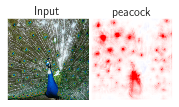

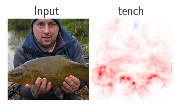

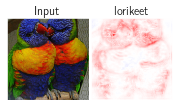

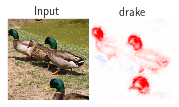

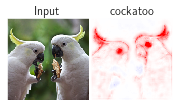

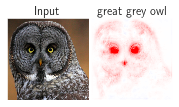

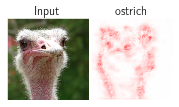

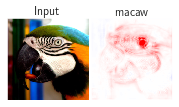

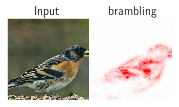

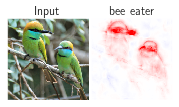

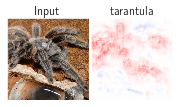

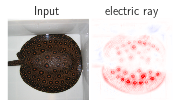

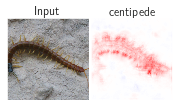

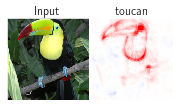

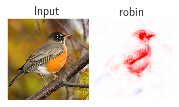

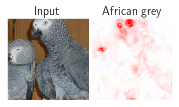

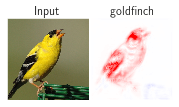

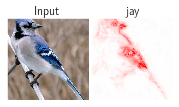

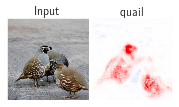

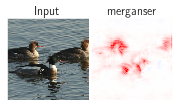

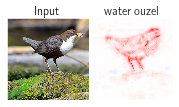

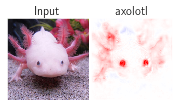

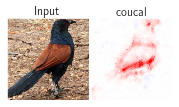

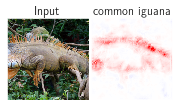

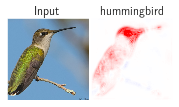

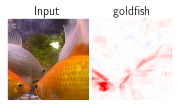

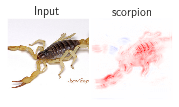

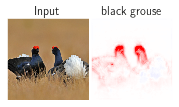

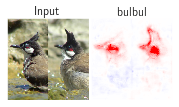

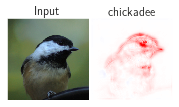

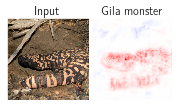

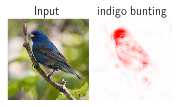

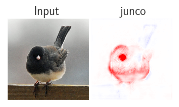

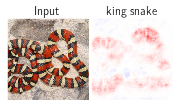

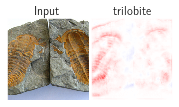

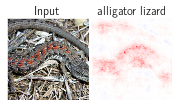

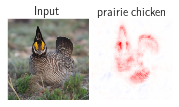

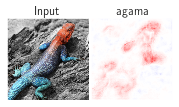

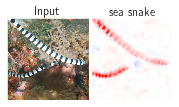

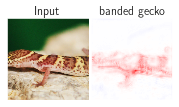

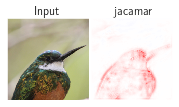

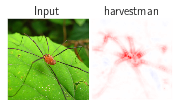

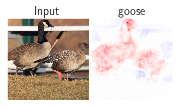

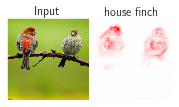

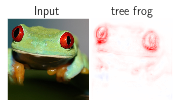

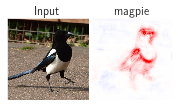

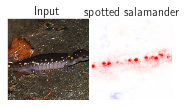

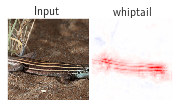

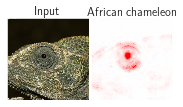

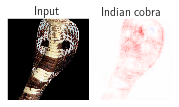

In [8]:
# if relative, the colorbar is normalised per image. Otherwise, the same colorbar
# is used for all shown images using the 'maxv' from above.
relative = False

fig_base_path = '/BS/restricted_networks/nobackup/tmp/figures/cvpr2021/final'
os.makedirs(fig_base_path, exist_ok=True)

for idx, (img, _atts) in enumerate(zip(ims, atts)):
    save_file = os.path.join(fig_base_path, "explanations_{}.pdf".format(idx))
    # True idx of image in dataset.
    true_idx = srtd_idcs[idx]
    class_name = name_map[tgt_idcs[idx]].split(",")[0]
    if "cockatoo" in class_name:
        class_name = "cockatoo"
    if "red-breasted" in class_name:
        class_name = "merganser"
    fig, axes = plt.subplots(1, 2, figsize=(3, 1.5))
    
    axes[0].imshow(img)
    axes[1].set_title(class_name, fontsize=12, pad=3)
    axes[0].set_title("Input", fontsize=12, pad=3)
    vrange = np.abs(_atts).flatten().max()
    # Plot contribution map just calls imshow with 'bwr' colormap and a scaling from [-vrange, vrange] of the colors
    opts = {"percentile": 99.99} if relative else {"vrange": maxv}
    plot_contribution_map(_atts, ax=axes[1], **opts)
    axes[0].set_xticks([])
    axes[0].set_yticks([]);
#     fig.tight_layout()
    plt.subplots_adjust(wspace=0)
#     fig.savefig(save_file, facecolor=bg_color, edgecolor="black")
    plt.show()


### Evaluate other explanation methods for comparison

In [9]:
from interpretability.explanation_methods.explainers.captum import IxG, GradCam, IntGrad, DeepLIFT, GB
from interpretability.explanation_methods.explainers.occlusion import Occlusion
from interpretability.explanation_methods.explainers.lime import Lime
from interpretability.explanation_methods.explainers.rise import RISE


In [10]:
img, tgt_idx = loader.dataset[srtd_idcs[0]]

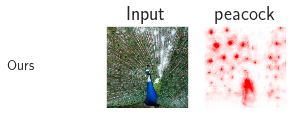

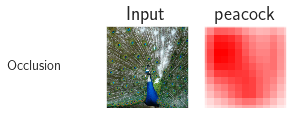

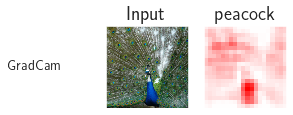

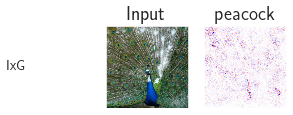

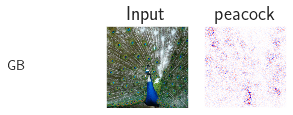

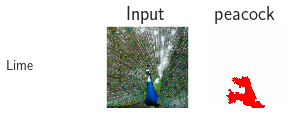

In [11]:
for explainer_method in ["Ours", Occlusion, GradCam, IxG, GB, Lime]:
    
    use_trainer = explainer_method == "Ours"
    trainer.explanation_mode(False)
    if not use_trainer and explainer_method.__name__ == "Occlusion":
        # bigger strides for fast evaluation
        params = {"ks": 50, "stride": 20}
    elif not use_trainer and explainer_method.__name__ == "Lime":
        # bigger strides for fast evaluation
        params = {"kernel_size": 4}
    else:
        params = {}
    tgt = tgt_idx.argmax().item()
    class_name = name_map[tgt].split(",")[0]
    if use_trainer:
        explainer = trainer
    else:    
        explainer = explainer_method(trainer, **params)
    att = to_numpy(explainer.attribute(img.cuda()[None], tgt))[0].sum(0)
    plot_fig, axes = plt.subplots(1, 3, figsize=(5, 3))
    # show orignal image
    axes[1].imshow(to_numpy_img(img))
    method = explainer_method if use_trainer else explainer_method.__name__
    # Name of the explanation method
    axes[0].text(0, 125,  "{:>10}".format(method), fontsize=14)

    # Plot contribution map just calls imshow with 'bwr' colormap and a scaling from [-vrange, vrange] of the colors
    opts = {"percentile": 99.99} if explainer_method != "Ours" else {"vrange": precomp_maxv}
    plot_contribution_map(att, ax=axes[2], **opts)

    
    # Plot white square where text is for easy formatting ... 
    axes[0].imshow(np.ones_like(to_numpy_img((img))))

    # Labels
    axes[2].set_title(class_name)
    axes[1].set_title("Input")

    # Just hide axes
    _ = [(ax.set_xticks([]), ax.set_yticks([])) for ax in axes[:2]]
    axes[0].axis("off")
    plt.show()